<a href="https://colab.research.google.com/github/vladoxNCL/Conway_Life/blob/main/fair_kruskal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libraries and constants

In [ ]:
import math
import networkx as nx
import random as rd

node_colors = {
    'f': 'red',
    'u': 'blue',
}

edge_colors = {
    'ff': 'red',
    'uu': 'blue',
    'uf': 'green',
}

seed = 42

## Functions

In [ ]:
def gen_pa_graph(n=20, p=0.15, pu=0.6, w_min=1, w_max=10, seed=None):
    """
    Args:
        n     : number of nodes
        p     : edge probability
        pu    : unfavoured node probability
        w_min : minimum edge weight
        w_max : maximum edge weight
        seed  : random seed

    Returns:
        C     : connected random graph with node PAs and weighted edges
    """
    # Set random seed
    rd.seed(seed)

    # generate graph and keep largest component
    G = nx.erdos_renyi_graph(n, p, seed=seed)
    cc = max(nx.connected_components(G))
    C = G.subgraph(cc)
    k =C.number_of_nodes()

    # generate pas: {u, f} with probas pu and 1 - pu
    pas = rd.choices(['u', 'f'], weights=[pu, 1 - pu], k=k)
    for i, n in enumerate(C.nodes):
        C.nodes[n]['pa'] = pas[i]

    # generate weights for edges
    weights = {e: rd.randint(w_min, w_max) for e in C.edges}

    # assign labels to edges: {uu, uf, ff} and weights [1..10]
    for e in C.edges:
        start = C.nodes[e[0]]['pa']
        end = C.nodes[e[1]]['pa']
        epa = f'{start}{end}' if start == end else 'uf'
        C.edges[e]['epa'] = epa
        C.edges[e]['weight'] = weights[e]

    return C

def fair_kruskal(G, strat='proba', seed=None):
    """
    Arg:
        G : weighted and PA labelled graph

    Returns:
        T : fair minimum spanning tree
    """
    # Set random seed
    rd.seed(seed)

    # categorise edges and keep weights
    epa = nx.get_edge_attributes(G, 'epa')
    epa_unique = list(set(epa.values()))
    epas = {
        u: [e for e in epa if epa[e] == u]
        for u in epa_unique
    }
    weights = nx.get_edge_attributes(G, 'weight')

    # copy graph nodes
    T = nx.Graph()
    T.add_nodes_from(G.nodes(data=True))

    # stop condition for tree
    while len(T.edges) < len(T.nodes) - 1:

        match strat:
            case 'proba':
                # choose edge type probabilistically
                total_edges = sum(len(epas[u]) for u in epa_unique)
                ws = [len(epas[u]) / total_edges for u in epa_unique]
                u = rd.choices(epa_unique, weights=ws, k=1)[0]
            case 'minority':
                # choose least represented edge type in T
                T_count = {
                    u: list(
                        nx.get_edge_attributes(T, 'epa').values()
                    ).count(u)
                    for u in epa_unique if len(epas[u]) > 0
                }
                least_rep = [
                    k for k, v in T_count.items() if v == min(T_count.values())
                ]
                u = rd.choice(least_rep)

        # get weights for the relevant edges and sort by weight
        u_weights = {e: weights[e] for e in epas[u]}

        # get the edge with the smallest weight
        e = sorted(u_weights.items(), key=lambda item: item[1])[0][0]

        # add edge if it doesn't form a cycle
        if not nx.has_path(T, *e):
            T.add_edge(*e)
            T.edges[e]['epa'] = epa[e]
            T.edges[e]['weight'] = weights[e]

        # remove edge from edges to consider
        epas[u].remove(e)

    return T

def graph_stats(G, print_stats=False):
    """
    Args:
        G           : graph
        print_stats : print stats

    Returns:
        stats       : graph's weight sum and edge diversity
    """
    # split edges by edge pa class
    epa = nx.get_edge_attributes(G, 'epa')
    epa_u = list(set(epa.values()))
    epas = {
        u: [e for e in epa if epa[e] == u] for u in epa_u
    }
    n_edges = G.number_of_edges()

    # sum of weights
    w_sum = sum(nx.get_edge_attributes(G, 'weight').values())

    # edge representation
    e_rep = {
        u: {
            'total': len(epas[u]),
            'p': len(epas[u]) / n_edges,
        } for u in epa_u
    }

    # edge diversity
    reps = [e_rep[u]['p'] for u in e_rep]
    norm_ent = - sum([r * math.log(r) for r in reps]) / math.log(len(reps))
    gini = sum([r * (1 - r) for r in reps])
    imb_ratio = max(reps) / min(reps)

    # stats dictionary
    stats = {
        'ws': w_sum,
        'er': e_rep,
        'ne': norm_ent,
        'gi': gini,
        'ir': imb_ratio,
    }

    if print_stats:
        print(f'Weight Sum:\t{w_sum}')
        print('Edge Proportions:')
        for e in e_rep:
            print(
                f'  {e}: {e_rep[e]["total"]:>3} \t{e_rep[e]["p"]:.3f}'
            )
        print(f'Norm. Entropy:\t{norm_ent:.3f}')
        print(f'Gini Index:\t{gini:.3f}')
        print(f'Imbal. Ratio:\t{imb_ratio:.3f}')

    return stats

def div_sim(G, T, print_sim=False):
    """
    Args:
        G : original graph
        T : spanning tree

    Returns:
        f : sum of edge diversity differences
    """
    s1 = graph_stats(G)
    s2 = graph_stats(T, print_stats=print_sim)

    f = 1 - sum([
        abs(s1['er'][epa]['p'] - s2['er'][epa]['p'])
        for epa in s1['er']
    ])

    if print_sim:
        print(f'Similarity:\t{f:.3f}')

    return f

def draw_graph(G, seed=None):
    """
    Arg:
        G : graph with PA and EPA labels

    Returns:
        None
    """
    e_colors = [edge_colors[G.edges[e]['epa']] for e in G.edges]
    n_colors = [node_colors[G.nodes[n]['pa']] for n in G.nodes]

    # place the nodes the same way
    pos = nx.spring_layout(G, seed=seed)

    nx.draw(
        G, with_labels=True, pos=pos,
        font_color='w',
        edge_color=e_colors, width=2,
        node_color=n_colors,
    )

## Sample graphs

Weight Sum:	149
Edge Proportions:
  uu:  15 	0.536
  uf:  10 	0.357
  ff:   3 	0.107
Norm. Entropy:	0.857
Gini Index:	0.574
Imbal. Ratio:	5.000


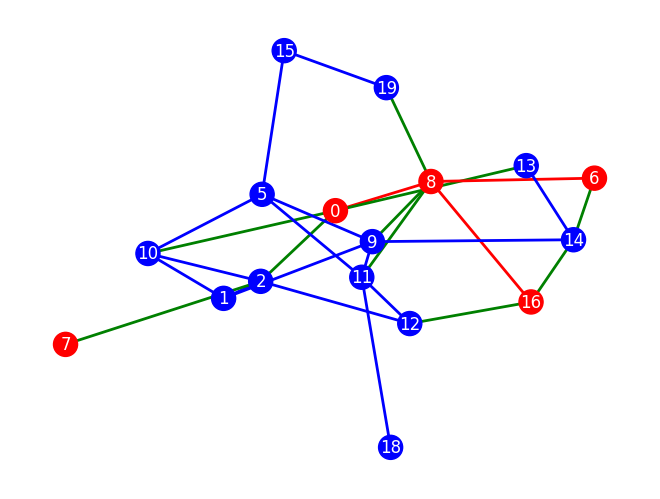

In [ ]:
# connected graph
C = gen_pa_graph(seed=seed)
graph_stats(C, print_stats=True)
draw_graph(C, seed=seed)

Weight Sum:	61
Edge Proportions:
  uu:   8 	0.500
  uf:   7 	0.438
  ff:   1 	0.062
Norm. Entropy:	0.802
Gini Index:	0.555
Imbal. Ratio:	8.000
Similarity:	0.839


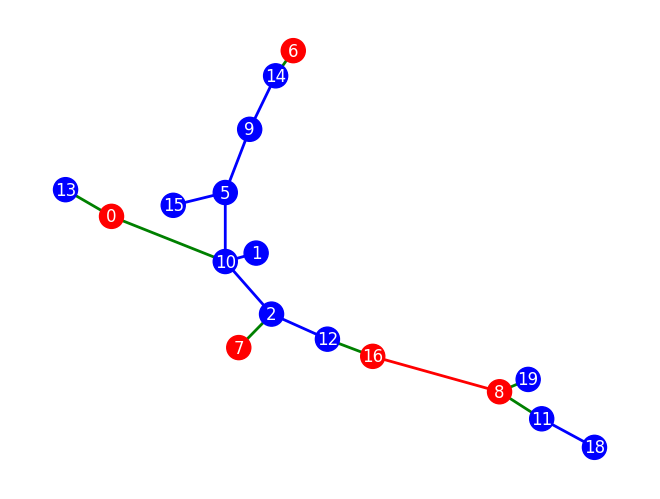

In [ ]:
# fair Kruskal (probabilistic)
T_fp = fair_kruskal(C, seed=seed)
div_sim(C, T_fp, print_sim=True)
draw_graph(T_fp, seed=seed)

Weight Sum:	60
Edge Proportions:
  uu:   7 	0.438
  uf:   6 	0.375
  ff:   3 	0.188
Norm. Entropy:	0.950
Gini Index:	0.633
Imbal. Ratio:	2.333
Similarity:	0.804


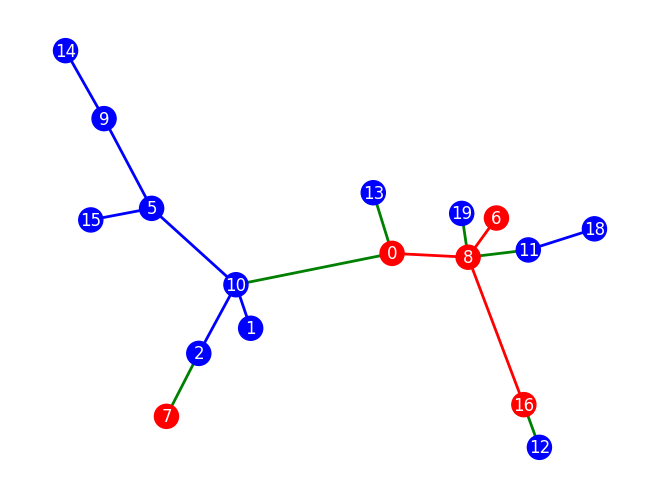

In [ ]:
# fair Kruskal (minority)
T_fm = fair_kruskal(C, strat='minority', seed=seed)
div_sim(C, T_fm, print_sim=True)
draw_graph(T_fm, seed=seed)

Weight Sum:	55
Edge Proportions:
  uu:   9 	0.562
  uf:   4 	0.250
  ff:   3 	0.188
Norm. Entropy:	0.896
Gini Index:	0.586
Imbal. Ratio:	3.000
Similarity:	0.786


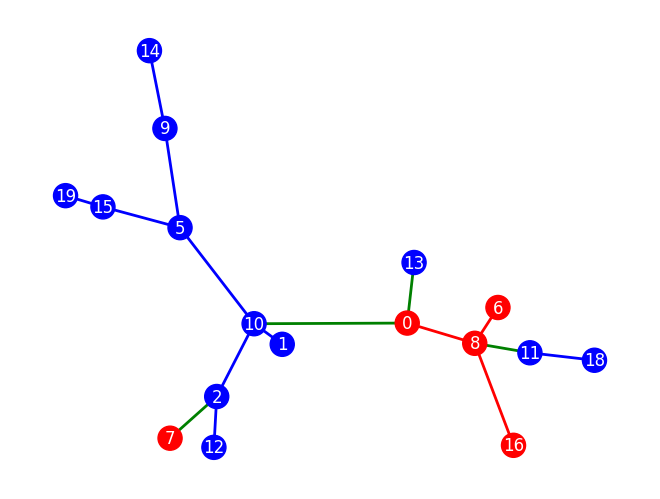

In [ ]:
# regular Kruskal
T2 = nx.minimum_spanning_tree(C)
div_sim(C, T2, print_sim=True)
draw_graph(T2, seed=seed)

# TO DO
- Design / run / analyse experiments
- Alternative fairness definitions
- Assign PAs to edges directly? (only U and F)
- More alternatives to adding labels to tree

[Nice Google page with diversity metrics](https://pair.withgoogle.com/explorables/measuring-diversity/)

## Metrics considered so far:
- Normalised Shannon Entropy
$$
    E = \frac{- \sum_{c \in C} p_c \log(p_c)}{\log(|C|)}
$$
- Gini Index
$$
    G = \sum_{c \in C}^n p_c (1 - p_c)
$$
- Imbalance Ratio
$$
    I = \frac{\max_{c \in C} p_c}{\min_{c \in C} p_c}
$$
- Similarity (with respect to original proportions)
$$
    S = 1 - \sum_{c \in C} \left| p_c(G) - p_c(T) \right|
$$

Where $C = \{\texttt{uu}, \texttt{ff}, \texttt{uf}\}$, and (0 -> no diversity, 1 -> high diversity).
